In [26]:
#!pip install pandas-profiling
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pandas.plotting import scatter_matrix
from sklearn import preprocessing

# Data preparation

In [8]:
users = pd.read_csv('users.csv',delimiter=',').drop_duplicates(subset='UserIdentifier', keep='first')

In [10]:
pers = pd.read_csv('personality.csv',delimiter=',').drop_duplicates(subset='UserIdentifier', keep='first')

In [50]:
df = pd.merge(pers, users, how='left', on= ['UserIdentifier']).drop("UserBrowser", axis=1)     

In [52]:
df.describe()

,A,B,C,D,E,D02,D03,D04,D05,D06,D07
count,1517.000000,1511.000000,1509.000000,1516.000000,1516.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000
mean,-0.047780,-0.005929,0.026164,-0.017736,0.011151,1980.468113,3.285996,2.866535,2.854701,6.238659,3.163708
std,1.130173,0.916369,0.733698,0.604658,0.548974,16.194393,0.804016,1.490299,1.447523,1.761124,1.315954
min,-3.617969,-3.997221,-2.827560,-2.119359,-1.575518,1900.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-0.810146,-0.612178,-0.474066,-0.436161,-0.370760,1972.000000,3.000000,2.000000,1.000000,5.000000,2.000000
50%,-0.003628,0.025672,-0.003446,-0.049930,-0.061014,1984.000000,3.000000,2.000000,3.000000,6.000000,3.000000
75%,0.747494,0.631377,0.499697,0.347349,0.362489,1992.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.051017,4.913192,2.516733,2.853188,1.901623,2004.000000,5.000000,7.000000,5.000000,10.000000,6.000000


In [53]:
df = df.dropna()

In [56]:
df["D01"] = np.where(df["D01"].str.contains("M"), 1, 0)

<ipython-input-56-c26b280e8c5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["D01"] = np.where(df["D01"].str.contains("M"), 1, 0)


In [58]:
cols_to_num = ['D02','D03','D04','D05','D06','D07']

In [59]:
df[cols_to_num] = df[cols_to_num].astype(int)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [67]:
df = df.rename(columns={"D01": "gender", "D02": "birth_year", "D03": "education", "D04": "empl_status",
                       "D05": "town_size", "D06": "financial_sit","D07": "household_size",})

# Inicial EDA

In [69]:
prof = ProfileReport(df.drop("UserIdentifier", axis=1))
prof.to_file(output_file='EDA.html')

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Analyzing correlations (demo vs psychotest)

In [76]:
data = df.drop("UserIdentifier", axis=1)

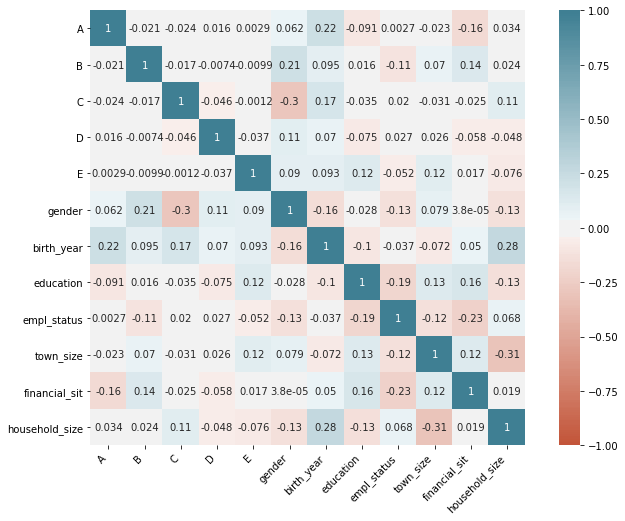

In [81]:
corr = data.corr()
plt.figure(figsize=(12,8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [103]:
corr.unstack().transpose()\
    .sort_values(ascending=False)\
    .drop_duplicates().head(15)        #small positive correlation between A and birth_year(so age), B and gender

household_size  household_size    1.000000
birth_year      household_size    0.276176
A               birth_year        0.222848
B               gender            0.210943
birth_year      C                 0.173262
education       financial_sit     0.158454
financial_sit   B                 0.143524
education       town_size         0.128515
town_size       financial_sit     0.123779
E               education         0.119737
town_size       E                 0.116363
household_size  C                 0.114722
gender          D                 0.108278
B               birth_year        0.095067
birth_year      E                 0.093038
dtype: float64

In [104]:
corr.unstack().transpose()\
    .sort_values(ascending=True)\
    .drop_duplicates().head(15)    #small negative correlation between gender and C

town_size      household_size   -0.311957
gender         C                -0.296490
financial_sit  empl_status      -0.225334
empl_status    education        -0.194311
financial_sit  A                -0.158781
birth_year     gender           -0.155755
education      household_size   -0.133377
gender         household_size   -0.132539
empl_status    gender           -0.128860
               town_size        -0.123605
               B                -0.113256
birth_year     education        -0.099772
A              education        -0.090601
E              household_size   -0.076048
education      D                -0.074718
dtype: float64

### Conclusion:  age and gender can have small correlation with psychological profile

# Clustering psycho data

In [107]:
psycho_data = data[['A', 'B', 'C', 'D', 'E']]

In [109]:
psycho_data_values = psycho_data.values

min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(psycho_data_values)

psycho_data_scaled = pd.DataFrame(x_scaled, columns=psycho_data.columns)

In [118]:
kmeans = KMeans()

In [119]:
kmeans.fit(psycho_data_scaled)   

KMeans()

In [126]:
groups = range(2,10)          

score = []

for n in groups:    
    kmeans = KMeans(n_clusters=n, random_state=10)
    predicted = kmeans.fit_predict(psycho_data_scaled)
    medium_silhouette = silhouette_score(psycho_data_scaled, predicted)
    print("n:", n,
          "medium silhouette:", medium_silhouette)
    score.append(medium_silhouette)

n: 2 medium silhouette: 0.18064554574133893
n: 3 medium silhouette: 0.1888612167865736
n: 4 medium silhouette: 0.17240879033743228
n: 5 medium silhouette: 0.1713611391962189
n: 6 medium silhouette: 0.1540832542517755
n: 7 medium silhouette: 0.14608146969613275
n: 8 medium silhouette: 0.1484079397632993
n: 9 medium silhouette: 0.14285481631864888


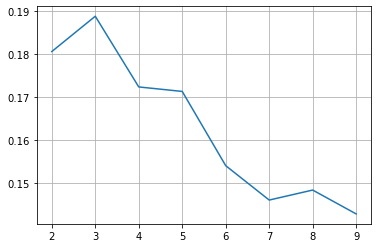

In [128]:
pd.Series(score, index=groups).plot(grid = True)  

In [133]:
kmeans= KMeans(n_clusters=3, random_state=10)
data["psycho_group"] = kmeans.fit_predict(psycho_data_scaled)

In [134]:
data

,A,B,C,D,E,gender,birth_year,education,empl_status,town_size,financial_sit,household_size,predicted,psycho_group
0,0.041197,-0.389188,-0.257404,0.732678,-0.769127,1,1954,3,4,2,6,2,1,1
1,-0.596461,0.620304,-0.611045,-0.256928,-0.244441,1,1963,2,2,2,7,2,2,0
2,-1.198166,-0.821102,0.298394,-0.031738,0.821793,0,1975,4,1,4,5,6,2,0
3,-0.344910,-1.611630,0.220709,-0.323851,-0.127276,0,1991,3,2,4,5,4,2,0
4,-0.365047,1.094319,-0.187957,-0.254589,0.554409,1,2000,3,3,1,7,6,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,-0.045188,-0.809351,0.713937,0.965781,-0.734136,0,1964,3,2,3,5,3,1,1
1517,-0.942098,1.000969,1.175538,-0.432683,-0.184118,0,2001,1,3,1,5,4,2,0
1518,-0.190014,0.151243,0.723002,0.368135,-0.778032,0,1981,4,2,4,4,4,1,1
1519,-1.514788,0.864807,0.275557,-0.609713,0.113668,1,1973,3,2,2,8,2,2,0


# Analyzing clusters

In [135]:
cols_for_final_corr = ['gender','birth_year','education','empl_status','town_size','financial_sit','household_size','psycho_group']

In [136]:
clustered_demo = data[cols_for_final_corr]

In [139]:
clustered_demo

,gender,birth_year,education,empl_status,town_size,financial_sit,household_size,psycho_group
0,1,1954,3,4,2,6,2,1
1,1,1963,2,2,2,7,2,0
2,0,1975,4,1,4,5,6,0
3,0,1991,3,2,4,5,4,0
4,1,2000,3,3,1,7,6,2
...,...,...,...,...,...,...,...,...
1515,0,1964,3,2,3,5,3,1
1517,0,2001,1,3,1,5,4,0
1518,0,1981,4,2,4,4,4,1
1519,1,1973,3,2,2,8,2,0


In [ ]:
for n in range(0,3):
    output_file = 'cluster_number_' + str(n) + '.html'
    temp_df = clustered_demo[clustered_demo['psycho_group']==n]
    temp_prof = ProfileReport(temp_df)
    temp_prof.to_file(output_file=output_file)

# Clusters: conclusions 

## Cluster 0

Mostly women (67% - more than in the whole population - 63%) <br>
Average birth year  1976 (a bit older than average in population - 1980) <br>
Mostly 4th and 3rd education level (similar to population)  <br>
Employment status (a bit higher than average in the population 2.91 vs 2.86) <br>
Town size (mostly 1st and 3rd - similar to the population) <br>
Financial situation (a bit higher than average in the population 6.47 vs 6.23) <br>
Household type (a bit more common 2nd compared to 3rd in the population, average similar) <br>

## Cluster 1

Mostly women (the same proportion as in the population) <br>
Average birth year  1981 (a bit younger than in the population) <br>
Mostly 3rd and 4th education level (lower than in the population)  <br>
Employment status (average: 2.88 vs 2.86 - a bit higher than in the population) <br>
Town size  (mostly 1st and 3rd - similar to the population)  <br>
Financial situation (average 6.03 - lower than in the population) <br>
Household type (average 3.26 vs 3.15 - higher) <br>

## Cluster 2

Mostly women (56% vs 63% in the population - smaller proportion) <br>
Average birth year  1984 (younger than in the population - 1980) <br>
Mostly 4th and 3rd education level (similar to population)   <br>
Employment status (average: 2.75 vs 2.86 in the population - lower) <br>
Town size (mostly 1st and 5th - different from the population) <br>
Financial situation (average 6.17 - lower than in the population) <br>
Household type (average 3.0 - lower than the average) <br>

## Clusters comparison

## Cluster 0  - the well-off

#### Most femenine cluster, the oldest average age, the highest employment status, the best financial situation

## Cluster 1 - the poor, traditional

#### Lower education level, the worst financial situation, the biggest household size

## Cluster 2  - the beginner

#### The least femenine, the youngest average age, the lowest employment status, the smallest household size, living also in the big cities